In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#%autoreload # When utils.py is updated
#from utils_unet_resunet import *
from ops import create_mask, metrics_AP, complete_nan_values
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from model.callbacks import UpdateWeights
import numpy as np
from model.models import UNET
from model.losses import WBCE
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import os
import gc

## Parameters

In [3]:
img_path = 'imgs' 
n_opt_layer = 26 #number of OPT layers, used to split de input data between OPT and SAR
exp = 2
times = 5

img_type = 'SAR'
cond = 'no_cloudy'

## Load file

In [4]:
final_mask1 = np.load(os.path.join(img_path, 'final_mask1.npy'))
print('Labels stack:', final_mask1.shape)
#h_, w_, channels = image_array.shape

Labels stack: (17730, 9203)


## Create tiles mask

mask:  (17730, 9203)
ref : (17730, 9203)


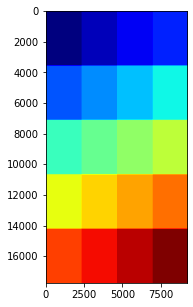

In [5]:
mask_tiles = create_mask(final_mask1.shape[0], final_mask1.shape[1], grid_size=(5, 4))
#image_array = image_array[:mask_tiles.shape[0], :mask_tiles.shape[1],:]
#final_mask1 = final_mask1[:mask_tiles.shape[0], :mask_tiles.shape[1]]

print('mask: ',mask_tiles.shape)
#print('image stack: ', image_array.shape)
print('ref :', final_mask1.shape)
plt.figure(figsize=(10,5))
plt.imshow(mask_tiles, cmap='jet')

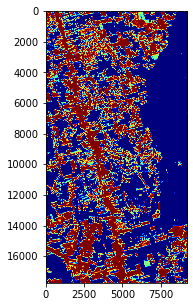

In [6]:
plt.figure(figsize=(10,5))
plt.imshow(final_mask1, cmap = 'jet')

## Define tiles for training, validation and tests.

In [7]:
tiles_tr = [1,3,5,8,11,13,14,20]
tiles_val = [6,19]
tiles_ts = (list(set(np.arange(20)+1)-set(tiles_tr)-set(tiles_val)))

mask_amazon_ts = np.zeros((mask_tiles.shape)).astype('float32')
for ts_ in tiles_ts:
    mask_amazon_ts[mask_tiles == ts_] = 1

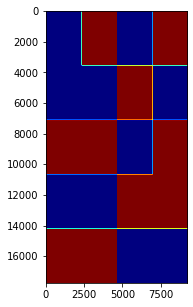

In [8]:
plt.figure(figsize=(10,5))
plt.imshow(mask_amazon_ts, cmap='jet')

In [9]:
path_exp = os.path.join(img_path, 'experiments', f'exp_{exp}')
path_models = os.path.join(img_path, 'models')
path_maps = os.path.join(img_path, 'pred_maps')

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)

In [10]:
mean_prob = np.load(os.path.join(path_maps, 'prob_mean.npy'))

(-0.5, 9202.5, 17729.5, -0.5)

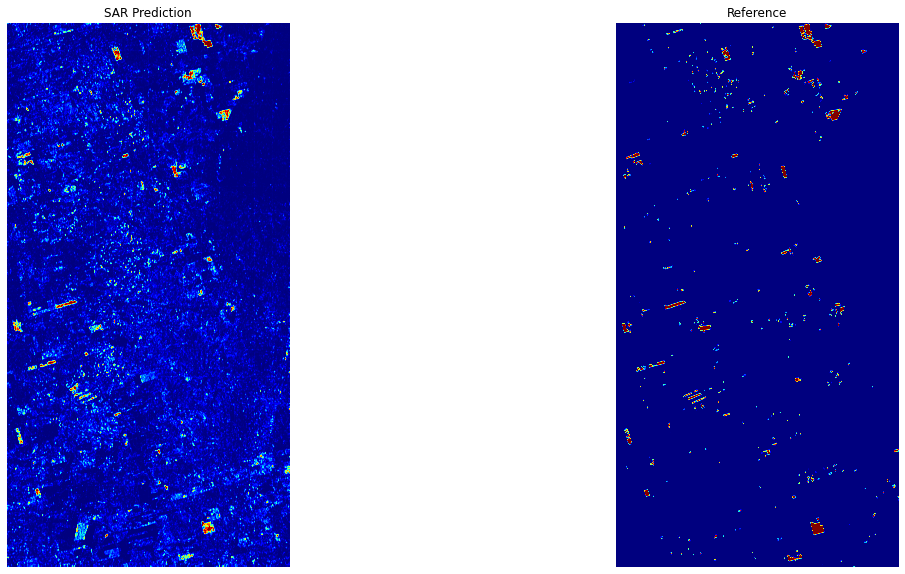

In [11]:
# Plot mean map and reference
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
plt.title(f'{img_type} Prediction')
ax1.imshow(mean_prob, cmap ='jet')
ax1.axis('off')

ax2 = fig.add_subplot(122)
plt.title('Reference')
ax2.imshow(tf.keras.utils.to_categorical(final_mask1, 3)[:,:,1], cmap ='jet')
ax2.axis('off')

In [12]:
# Computing metrics
t0 = time.time()
mean_prob = mean_prob[:final_mask1.shape[0], :final_mask1.shape[1]]


ref1 = np.ones_like(final_mask1).astype(np.float32)

ref1 [final_mask1 == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = final_mask1==1
    
Npoints = 50

Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
ProbList = np.linspace(Pmax,0,Npoints)

metrics = metrics_AP(ProbList, mean_prob, final_mask1, mask_amazon_ts, 625, 3)
   
np.save(os.path.join(path_exp, 'acc_metrics.npy'),metrics)

print(f'elapsed time: {(time.time()-t0)/60} mins')

elapsed time: 56.9605252623558 mins


In [13]:
# Complete NaN values
metrics_copy = np.array(metrics)
metrics_copy = complete_nan_values(metrics_copy)


SAR mAP 0.6397558980994064


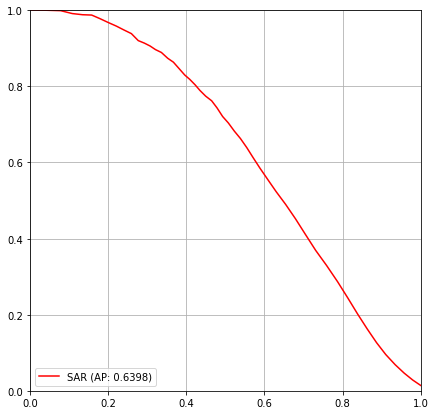

In [14]:
# Comput Mean Average Precision (mAP) score 
Recall = metrics_copy[:,0]
Precision = metrics_copy[:,1]
AA = metrics_copy[:,2]
   
DeltaR = Recall[1:]-Recall[:-1]
AP = np.sum(Precision[:-1]*DeltaR)
print(f'{img_type} mAP', AP)


# Plot Recall vs. Precision curve
plt.figure(figsize=(7,7))
plt.plot(metrics_copy[:,0],metrics_copy[:,1], 'r-', label = f'{img_type} (AP: {AP:.4f})')
plt.legend(loc="lower left")
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_xlim([0,1])
#plt.plot(metrics_copy[:,0],metrics_copy[:,2])
plt.grid()